#목차
###1. 데이터
  * 이유
  * 가설
  * 전처리

###2. 모델
  * 이유
  * 선정
  * 학습 & 결과

###3. 회고
  * 한계점
  * 회고

#1. 데이터
   * 이유  
   저는 운동하는 것을 좋아해서 아무래도 건강관리에 관심이 많이 갔습니다. 또한 의료계열 쪽의 회사에서 관심을 가질만한 것이라 생각하여 결정하게 되었습니다.
   * 가설 
   이 분석을 통해서 환자와 의사 둘 다 진료의 편의성의 증대로 인해 효용이 증가할 것이라고 생각한다. 또한 도심에서 멀리 떨어진 외각 지역에서 단순한 X-ray를 통한 질병의 예방에도 도움이 된다고 생각된다. 

   * 전처리  
1.데이터의 정규화(Normalization)  
2.노이즈 및 이상치(Outlier) 제거  
3.타겟 레이블(Label or Ground Truth) 생성 혹은 선택 등

In [ ]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

resnet = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#경로 설정
train_dir = '/content/drive/MyDrive/chest_xray/train'
test_dir = '/content/drive/MyDrive/chest_xray/test'


#정규화(Nomalization)
train_datagen = ImageDataGenerator(rescale=1/255) 
validation_datagen=ImageDataGenerator(rescale=1/255)


In [ ]:
#훈련, 검증
train_set = train_datagen.flow_from_directory(train_dir,
                                                    classes=['NORMAL', 'PNEUMONIA'],
                                                    batch_size = 20,
                                                    target_size = (224, 224),
                                                    class_mode='binary',
                                                    seed = 42)

validation_set = validation_datagen.flow_from_directory(test_dir,
                                                              classes=['NORMAL', 'PNEUMONIA'],
                                                              batch_size = 20,
                                                              target_size = (224, 224),
                                                              class_mode = 'binary',
                                                              seed = 42)


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_set

In [ ]:
for layer in resnet.layers:
    layer.trainable = False

#2. 모델

In [ ]:
from tensorflow.keras import callbacks

#과적합 방지
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)


In [ ]:
#Fully-conneted layer
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)

predictions = Dense(1, activation='sigmoid')(x) # 출력층을 설계합니다.
model = Model(resnet.input, predictions)

model.compile(optimizer = keras.optimizers.Adam(5e-5), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [ ]:
#모델 훈련
history = model.fit(train_set,
                         batch_size = 20,
                         steps_per_epoch = 30,
                         epochs = 30,
                         callbacks=[early_stopping],
                         validation_data = validation_set,
                         validation_steps = 20)

Epoch 1/30
30/30 [==============================] - 24s 559ms/step - loss: 0.4727 - binary_accuracy: 0.7900 - val_loss: 0.4890 - val_binary_accuracy: 0.7350
Epoch 2/30
30/30 [==============================] - 14s 469ms/step - loss: 0.2950 - binary_accuracy: 0.8750 - val_loss: 0.4053 - val_binary_accuracy: 0.8150
Epoch 3/30
30/30 [==============================] - 14s 457ms/step - loss: 0.2269 - binary_accuracy: 0.9233 - val_loss: 0.5181 - val_binary_accuracy: 0.7375
Epoch 4/30
30/30 [==============================] - 13s 451ms/step - loss: 0.2022 - binary_accuracy: 0.9250 - val_loss: 0.4234 - val_binary_accuracy: 0.8075
Epoch 5/30
30/30 [==============================] - 14s 457ms/step - loss: 0.1634 - binary_accuracy: 0.9450 - val_loss: 0.3738 - val_binary_accuracy: 0.8275
Epoch 6/30
30/30 [==============================] - 14s 465ms/step - loss: 0.2099 - binary_accuracy: 0.9183 - val_loss: 0.3561 - val_binary_accuracy: 0.8250
Epoch 7/30
30/30 [==============================] - 14s 46

In [ ]:
result = model.evaluate(train_set, verbose=2)

262/262 - 67s - loss: 0.1189 - binary_accuracy: 0.9558 - 67s/epoch - 258ms/step


In [ ]:
print('train_lose =',result[0])
print('train_accuracy =',result[1])

train_lose = 0.11894737929105759
train_accuracy = 0.9558486342430115


In [ ]:
result = model.evaluate(validation_set, verbose=2)

32/32 - 8s - loss: 0.2915 - binary_accuracy: 0.8558 - 8s/epoch - 265ms/step


In [ ]:
print('val_lose =',result[0])
print('val_accuracy =',result[1])

val_lose = 0.2915206849575043
val_accuracy = 0.8557692170143127


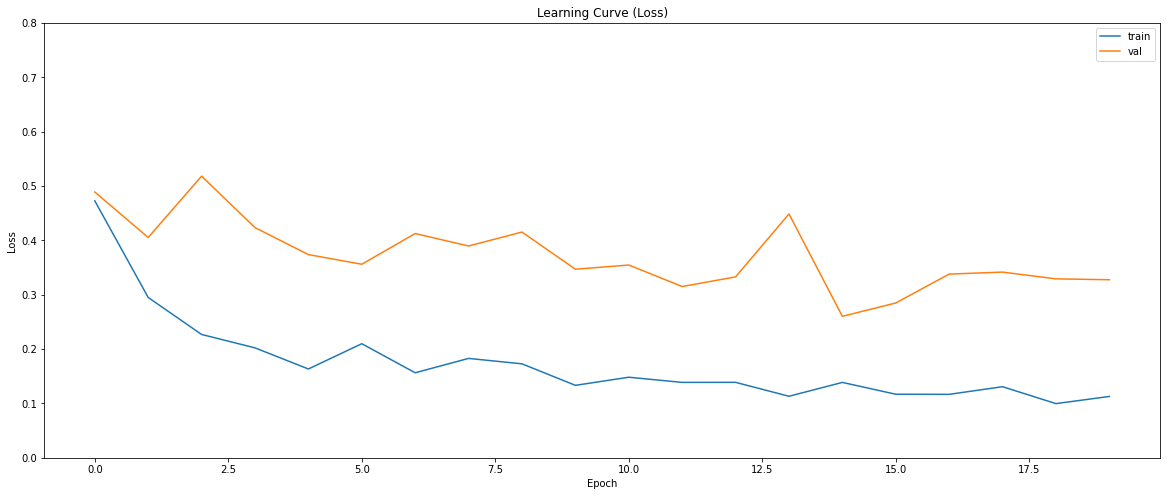

In [ ]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.8)
ax.legend(['train', 'val'], loc='best')
plt.show()

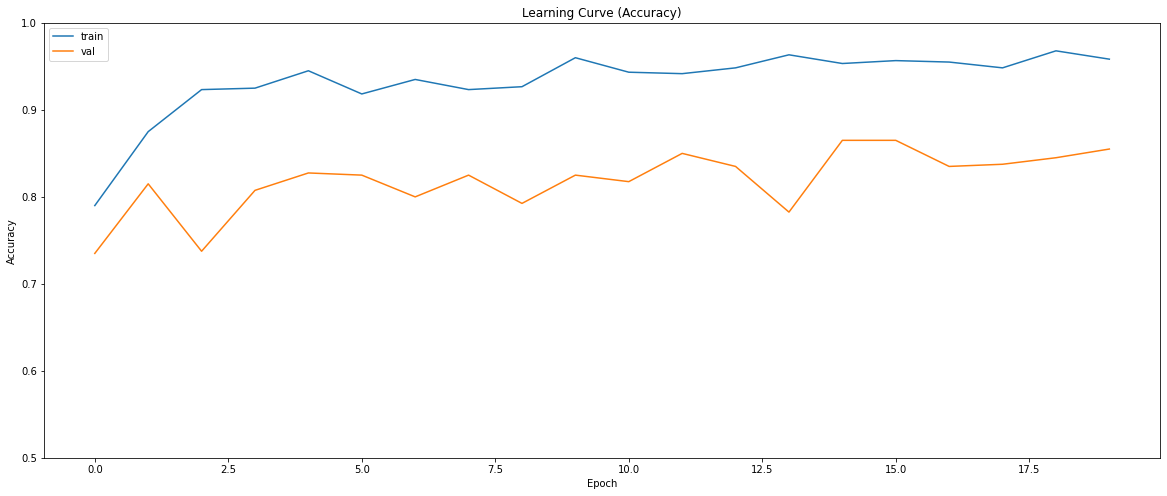

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.5, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

#3. 회고